In [2]:
import torch
from torch.nn import Sequential as Seq, Linear, ReLU
import os
print("PyTorch has version {}".format(torch.__version__))

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops
from torch_geometric.data import Data

PyTorch has version 1.13.1+cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os.path as osp
import numpy as np
import torch
from torch_geometric.datasets import AMiner
from torch_geometric.nn import MetaPath2Vec
from torch_sparse import SparseTensor

In [4]:
# load the dataset
path = osp.join('..', 'data', 'AMiner')
dataset = AMiner(path)
data = dataset[0]

Extracting ../data/AMiner/net_aminer.zip
Extracting ../data/AMiner/raw/label.zip
Processing...
Done!


In [5]:
print(data)

HeteroData(
  author={
    y=[246678],
    y_index=[246678],
    num_nodes=1693531
  },
  venue={
    y=[134],
    y_index=[134],
    num_nodes=3883
  },
  paper={ num_nodes=3194405 },
  (paper, written_by, author)={ edge_index=[2, 9323605] },
  (author, writes, paper)={ edge_index=[2, 9323605] },
  (paper, published_in, venue)={ edge_index=[2, 3194405] },
  (venue, publishes, paper)={ edge_index=[2, 3194405] }
)


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
metapath = [
    ("author", "writes", "paper"),
    ("paper", "published_in", "venue"),
    ("venue", "publishes", "paper"),
    ("paper", "written_by", "author"),
]

In [7]:
metapath = [
    ("author", "writes", "paper"),
    ("paper", "published_in", "venue"),
    ("venue", "publishes", "paper"),
    ("paper", "written_by", "author"),
]

print(metapath[0][0], metapath[-1][-1])
types = set([x[0] for x in metapath])
types = sorted(list(types))
print(types)

author author
['author', 'paper', 'venue']


In [ ]:
a= torch.nn.Embedding(6, 5)
b=torch.tensor([[1,2,3], [2,3,4]])
start, rest = b[:, 0], b[:, 1:].contiguous()
print(a)
print(a(start))
print(a(rest))
print(a(start).view(b.size(0), 1, 5))
print(a(rest.view(-1)).view(b.size(0), -1, 5),9)
print(a(rest).view(b.size(0), -1, 5),10)
C = a(start).view(b.size(0), 1, 5)
D = a(rest).view(b.size(0), -1, 5)
print(C.shape)
print(D.shape)
print(torch.einsum('bij,bkj->bk', [C, D]).view(-1))
print((C*D).sum(dim=-1).view(-1))

Embedding(6, 5)
tensor([[ 1.6857,  1.6211, -0.1350, -1.0348,  0.3898],
        [-0.8906, -0.1827, -0.3768, -0.7859, -0.1050]],
       grad_fn=<EmbeddingBackward0>)
tensor([[[-0.8906, -0.1827, -0.3768, -0.7859, -0.1050],
         [-1.0200, -0.3554,  2.8968,  0.0305,  0.7583]],

        [[-1.0200, -0.3554,  2.8968,  0.0305,  0.7583],
         [-0.8865,  0.7388, -0.2992,  1.5521,  0.3665]]],
       grad_fn=<EmbeddingBackward0>)
tensor([[[ 1.6857,  1.6211, -0.1350, -1.0348,  0.3898]],

        [[-0.8906, -0.1827, -0.3768, -0.7859, -0.1050]]],
       grad_fn=<ViewBackward0>)
tensor([[[-0.8906, -0.1827, -0.3768, -0.7859, -0.1050],
         [-1.0200, -0.3554,  2.8968,  0.0305,  0.7583]],

        [[-1.0200, -0.3554,  2.8968,  0.0305,  0.7583],
         [-0.8865,  0.7388, -0.2992,  1.5521,  0.3665]]],
       grad_fn=<ViewBackward0>) 9
tensor([[[-0.8906, -0.1827, -0.3768, -0.7859, -0.1050],
         [-1.0200, -0.3554,  2.8968,  0.0305,  0.7583]],

        [[-1.0200, -0.3554,  2.8968,  0.0305,  

In [8]:
from torch.utils.data import DataLoader
def sample(src, subset, dummy_idx):

    mask = subset < dummy_idx
    rowcount = torch.zeros_like(subset)
    rowcount[mask] = src.storage.rowcount()[subset[mask]]
    mask = mask & (rowcount > 0)
    offset = torch.zeros_like(subset)
    offset[mask] = src.storage.rowptr()[subset[mask]]

    rand = torch.rand((rowcount.size(0), 1), device=subset.device)
    rand.mul_(rowcount.to(rand.dtype).view(-1, 1))
    rand = rand.to(torch.long)
    rand.add_(offset.view(-1, 1))

    col = src.storage.col()[rand]
    col[~mask] = dummy_idx
    return col

class metapath2vec(torch.nn.Module):
  def __init__(self, edge_index_dict, emb_dim, metapath, walk_length, context_size, walks_per_node, negative_size, num_nodes_dict, types):
    super().__init__()

    adj_dict = {}

    for keys, edge_index in edge_index_dict.items():
      shape = (num_nodes_dict[keys[0]], num_nodes_dict[keys[-1]])
      row, col = edge_index
      adj = SparseTensor(row=row, col=col, sparse_sizes = shape)
      adj = adj.to('cpu')
      adj_dict[keys] = adj
    
    self.adj_dict = adj_dict
    self.emb_dim = emb_dim
    self.metapath = metapath
    self.walk_length = walk_length
    self.context_size = context_size
    self.walks_per_node = walks_per_node
    self.negative_size = negative_size
    self.num_nodes_dict = num_nodes_dict

    count = 0
    self.start, self.end = {}, {}
    for key in types:
      self.start[key] = count
      count += self.num_nodes_dict[key]
      self.end[key] = count
    
    offset = [self.start[metapath[0][0]]]
    offset += [self.start[keys[-1]] for keys in metapath] * int(self.walk_length)
    offset = offset[:self.walk_length+1]
    self.offset = torch.tensor(offset)

    self.embedding = torch.nn.Embedding(count+1, emb_dim, sparse = True)
    self.dummy_idx = count

    self.embedding.reset_parameters()

  def forward(self, node_type, batch):
    emb = self.embedding.weight[self.start[node_type]:self.end[node_type]]
    return emb if batch is None else emb.index_select(0, batch)

  def loader(self, **kwargs):
    return DataLoader(range(self.num_nodes_dict[self.metapath[0][0]]), collate_fn = self._sample, **kwargs)

  def _pos_sample(self, batch):
    batch = batch.repeat(self.walks_per_node)
    rws = [batch]
    for i in range(self.walk_length):
      keys = self.metapath[i % len(self.metapath)]
      batch = sample(self.adj_dict[keys], batch, dummy_idx = self.dummy_idx).view(-1)
      rws.append(batch)
    rw = torch.stack(rws, dim=-1)
    rw.add_(self.offset.view(1, -1))

    walks = []

    for j in range(2+self.walk_length-self.context_size):
      walks.append(rw[:, j:j+self.context_size])
    return torch.cat(walks, dim = 0)

  def _neg_sample(self, batch):
    batch = batch.repeat(self.walks_per_node * self.negative_size)

    rws = [batch]

    for i in range(self.walk_length):
      keys = self.metapath[i%len(self.metapath)]
      batch = torch.randint(0, self.num_nodes_dict[keys[-1]], (batch.size(0), ), dtype=torch.long)
      rws.append(batch)
    rw = torch.stack(rws, dim=-1)
    rw.add_(self.offset.view(1, -1))
    walks = []

    for j in range(2+self.walk_length-self.context_size):
      walks.append(rw[:, j:j+self.context_size])
    return torch.cat(walks, dim = 0)    
    
  def _sample(self, batch):
    batch = torch.tensor(batch, dtype = torch.long)
    return self._pos_sample(batch), self._neg_sample(batch)
  
  def test(self, train_z, train_y, test_z, test_y, solver: str = "lbfgs", multi_class: str = "auto", *args, **kwargs):

      from sklearn.linear_model import LogisticRegression

      clf = LogisticRegression(solver=solver, multi_class=multi_class, *args,
                                **kwargs).fit(train_z.detach().cpu().numpy(),
                                              train_y.detach().cpu().numpy())
      return clf.score(test_z.detach().cpu().numpy(), test_y.detach().cpu().numpy())

  
  def loss(self, pos, neg):
    center, neighbor = pos[:, 0], pos[:, 1:].contiguous()
    center_embedding = self.embedding(center).view(pos.size(0), 1, self.emb_dim)
    neighbor_embedding = self.embedding(neighbor).view(pos.size(0), -1, self.emb_dim)
    positive_loss=-torch.log(torch.sigmoid(torch.einsum('bij,bkj->bk', [center_embedding,neighbor_embedding]).view(-1))+1e-15).mean()

    center, neighbor = neg[:, 0], neg[:, 1:].contiguous()
    center_embedding = self.embedding(center).view(neg.size(0), 1, self.emb_dim)
    neighbor_embedding = self.embedding(neighbor).view(neg.size(0), -1, self.emb_dim)
    negative_loss=-torch.log(1-torch.sigmoid(torch.einsum('bij,bkj->bk', [center_embedding,neighbor_embedding]).view(-1))+1e-15).mean()

    return positive_loss+negative_loss





In [ ]:
A = torch.tensor([1,2,3])
A.repeat(3)
rws=[]
for i in range(4):
  rws.append(torch.rand((6,)))
torch.stack(rws, dim=-1)+torch.tensor([2,3,4,10])

tensor([[ 2.4213,  3.6363,  4.0770, 10.3488],
        [ 2.6407,  3.4808,  4.7410, 10.4496],
        [ 2.7412,  3.9878,  4.5655, 10.7562],
        [ 2.2434,  3.0709,  4.8377, 10.7649],
        [ 2.6968,  3.9707,  4.2000, 10.7863],
        [ 2.9490,  3.1410,  4.7825, 10.0384]])

In [ ]:
B = torch.tensor([1,3,5,6,7], [0,3,4,5,6], [])

In [9]:
metapath = [
    ("author", "writes", "paper"),
    ("paper", "published_in", "venue"),
    ("venue", "publishes", "paper"),
    ("paper", "written_by", "author"),
]


model = metapath2vec(data.edge_index_dict, 
                     emb_dim=128,
                     metapath=metapath,
                     walk_length=10, 
                     context_size=7,
                     walks_per_node=10,
                     negative_size=5,
                     num_nodes_dict=data.num_nodes_dict,
                     types=types
                    ).to(device)

In [10]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=0)

# Inizialize optimizer
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [11]:
def train(epoch, log_steps=500, eval_steps=1000):
    model.train()

    total_loss = 0
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % log_steps == 0:
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Loss: {total_loss / log_steps:.4f}'))
            total_loss = 0

        if (i + 1) % eval_steps == 0:
            acc = test()
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Acc: {acc:.4f}'))
    return total_loss
@torch.no_grad()
def test(train_ratio=0.1):
    model.eval()

    z = model('author', batch=data.y_index_dict['author'].to(device))
    y = data.y_dict['author']

    perm = torch.randperm(z.size(0))
    train_perm = perm[:int(z.size(0) * train_ratio)]
    test_perm = perm[int(z.size(0) * train_ratio):]

    return model.test(z[train_perm], y[train_perm], z[test_perm],
                      y[test_perm], max_iter=150)

In [12]:
for idx, (pos_rw, neg_rw) in enumerate(loader):
    if idx == 10: break
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([6400, 7]) torch.Size([32000, 7])
1 torch.Size([6400, 7]) torch.Size([32000, 7])
2 torch.Size([6400, 7]) torch.Size([32000, 7])
3 torch.Size([6400, 7]) torch.Size([32000, 7])
4 torch.Size([6400, 7]) torch.Size([32000, 7])
5 torch.Size([6400, 7]) torch.Size([32000, 7])
6 torch.Size([6400, 7]) torch.Size([32000, 7])
7 torch.Size([6400, 7]) torch.Size([32000, 7])
8 torch.Size([6400, 7]) torch.Size([32000, 7])
9 torch.Size([6400, 7]) torch.Size([32000, 7])


In [13]:
loss_list = []
acc_list = []
for epoch in range(1, 10):
    loss=train(epoch)
    acc = test()
    print(f'Epoch: {epoch}, Accuracy: {acc:.4f}')
    loss_list.append(loss)
    acc_list.append(acc)

Epoch: 1, Step: 00500/13231, Loss: 8.2887
Epoch: 1, Step: 01000/13231, Loss: 6.3240
Epoch: 1, Step: 01000/13231, Acc: 0.2756
Epoch: 1, Step: 01500/13231, Loss: 5.8050
Epoch: 1, Step: 02000/13231, Loss: 5.5781
Epoch: 1, Step: 02000/13231, Acc: 0.2751
Epoch: 1, Step: 02500/13231, Loss: 5.3781
Epoch: 1, Step: 03000/13231, Loss: 5.2019
Epoch: 1, Step: 03000/13231, Acc: 0.2733
Epoch: 1, Step: 03500/13231, Loss: 5.0312
Epoch: 1, Step: 04000/13231, Loss: 4.8736
Epoch: 1, Step: 04000/13231, Acc: 0.2743
Epoch: 1, Step: 04500/13231, Loss: 4.7249
Epoch: 1, Step: 05000/13231, Loss: 4.5827
Epoch: 1, Step: 05000/13231, Acc: 0.2728
Epoch: 1, Step: 05500/13231, Loss: 4.4445
Epoch: 1, Step: 06000/13231, Loss: 4.3150
Epoch: 1, Step: 06000/13231, Acc: 0.2765
Epoch: 1, Step: 06500/13231, Loss: 4.1901
Epoch: 1, Step: 07000/13231, Loss: 4.0718
Epoch: 1, Step: 07000/13231, Acc: 0.2801
Epoch: 1, Step: 07500/13231, Loss: 3.9558
Epoch: 1, Step: 08000/13231, Loss: 3.8466
Epoch: 1, Step: 08000/13231, Acc: 0.2887


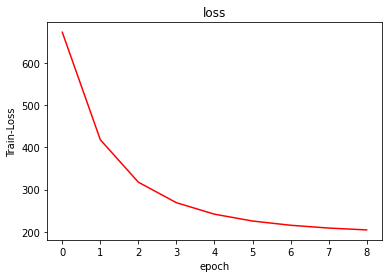

In [14]:
import matplotlib.pyplot as plt
plt.plot(loss_list, 'r')

plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('Train-Loss')

plt.show()

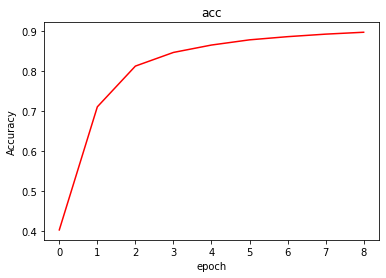

In [15]:
plt.plot(acc_list, 'r')

plt.title('acc')
plt.xlabel('epoch')
plt.ylabel('Accuracy')

plt.show()